# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

<a id='intro'></a>

## Оглавление

[Введение](#chapter2)

[Изучение общей информации](#chapter3)

[Деление данных на выборки](#chapter4)

[Исследование моделей](#chapter5)

[Проверка качества модели](#chapter6)

[Провека модели на вменяемость](#chapter7)

[Общий вывод](#chapter8)

<a id='chapter2'></a>

## Введение


Многие клиенты оператора "Мегалайн" пользуются архивными тарифами и не переходят на новые. Для более активного пользования новыми тарифами компания хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям наиболее подходящий для них новый тариф: "Смарт" или "Ультра".

Таким образом, цель данной работы: построить модель для задачи классификации, которая выберет подходящий тариф.

В качестве исходной информации нам передали данные о поведении клиентов, которые уже перешли на эти тарифы.


<a id='chapter3'></a>

## 1. Откройте и изучите файл


Для начала загрузим исходные данные.


In [1]:
#импорт необходимых библиотек
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
#загрузка исходной информации
data = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
#просмотр первых строк данных
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
#информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB



В таблице содержится информация по 3214 пользователям. Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

Итого в таблице пять столбцов:

* <i> calls </i> — количество звонков

* <i> minutes </i> — суммарная длительность звонков в минутах

* <i> messages </i> — количество sms-сообщений

* <i> mb_used </i> — израсходованный интернет-трафик в Мб

* <i> is_ultra </i> — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)


Проведем небольшую проверку данных перед выполнением работы.


In [5]:
#проверка количества дубликатов
data.duplicated().sum()

0

In [6]:
#проверка количества пропущенных значений
data.isnull().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [7]:
#статистика по данным
data.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


### Вывод


Мы загрузили и проанализировали исходные данные. Предобработка данных не требуется: в таблице нет ни дубликатов, ни пропущенных значений, ни заметных артефактов в статистике по колонкам (к примеру, нет значений меньше 0, информация по тарифам принимает только два значения: 0 или 1).

Значит можем приступить к следующему этапу - построению модели.


[Вернуться к оглавлению](#intro)

<a id='chapter4'></a>

## 2. Разбейте данные на выборки


Перед нами стоит задача классификации, т.е. тип целевого признака - категориальный. В данном случае у нас только две категории - тариф "Смарт" или тариф "Ультра".

Тип обучения - с учителем. Из общей таблицы выделим новые переменные: вопросы - признаки и ответ - целевой признак, т.е. столбец <i> is_ultra </i>.


In [8]:
#объявление новых переменных
features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra']


Тестовой выборки для предсказывания значений у нас нет. Поэтому необходимо общий набор данных разделить на три части: обучающую выборку, валидационную и тестовую в соотношении 3:1:1.

На обучающей выборке мы обучим модель, на валидационной - проверочной - подберем гиперпараметры.


In [9]:
#выделим тестовую выборку
data_features, features_test, data_target, target_test = (
train_test_split(features, target, test_size=0.2, random_state=0)
)
#выделим обучающую и валидационную выборки
features_train, features_valid, target_train, target_valid =(
train_test_split(data_features, data_target, test_size=0.25, random_state=0)
)

In [10]:
print('Количество объектов в обучающей выборке:', len(features_train))
print('Количество объектов в валидационной выборке:', len(features_valid))
print('Количество объектов в тестовой выборке:', len(features_test))

Количество объектов в обучающей выборке: 1928
Количество объектов в валидационной выборке: 643
Количество объектов в тестовой выборке: 643


### Вывод


Данные разбиты на три выборки: обучающую, валидационную и тестовую в соотношении 3:1:1. Мы готовы к тому, чтобы приступить к следующему этапу - выбору подходящей модели.


[Вернуться к оглавлению](#intro)

<a id='chapter5'></a>

## 3. Исследуйте модели


В данный момент нам известны три алгоритма классификации:

* дерево решений

* случайный лес

* логистическая регрессия


Подберем модель с наибольшей долей правильных ответов и в дальнейшем будем работать только с ней.


### Дерево решений


Построим модель с помощью дерева решений и подберем глубину дерева с наилучшим значением параметра <i> accuracy </i> - доли правильных ответов.


In [11]:
#зададим переменные, в которые сохраним наилучшую модель и результаты
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
#создадим пустой датафрейм, с помощью которого в дальнейшем построим график
model_tree = pd.DataFrame(columns=['depth', 'result'])
#в цикле перебираем значения глубины дерева
for depth in range(1, 11):
    #задаем модель с текущей глубиной
    model = DecisionTreeClassifier(random_state=0, max_depth=depth)
    #обучаем модель на обучающей выборке
    model.fit(features_train, target_train)
    #предсказываем результаты на валидационной выборке
    predictions = model.predict(features_valid)
    #рассчитываем значение accuracy
    result = accuracy_score(target_valid, predictions)
    model_tree.loc[depth-1, 'depth'] = depth
    model_tree.loc[depth-1, 'result'] = result
    #выбираем наилучший результат
    if result > best_result_tree:
        best_model_tree = model
        best_result_tree = result
        best_depth_tree = depth
print('Наилучшая accuracy:', best_result_tree, 'с глубиной:', best_depth_tree)

Наилучшая accuracy: 0.8211508553654744 с глубиной: 5


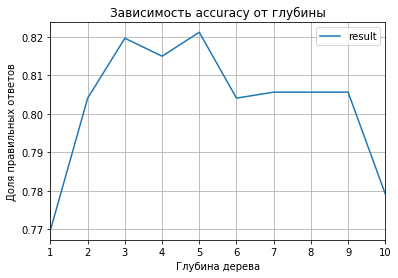

In [12]:
#построим график зависимости accuracy от глубины дерева
model_tree.plot(x='depth', y='result', grid=True)
plt.title('Зависимость accuracy от глубины')
plt.xlabel('Глубина дерева')
plt.ylabel('Доля правильных ответов')
plt.show()


Итак, видим, что наибольшая доля правильных ответов при глубине дерева - 5.


### Случайный лес


Сейчас построим модель с помощью алгоритма "случайный лес". При этом будем варьировать два гиперпараметра - глубину дерева и количество деревьев.


In [13]:
#зададим переменные, в которые сохраним наилучшую модель и результаты
best_model_forest = None
best_result_forest = 0
best_depth_forest = 0
best_est_forest = 0
#в цикле перебираем значения глубины дерева и количество деревьев
for est in range(10, 51, 5):
    for depth in range(1, 11):
        #задаем модель с текущей глубиной
        model = RandomForestClassifier(random_state=0, n_estimators=est, max_depth=depth)
        #обучаем модель на обучающей выборке
        model.fit(features_train, target_train)
        #предсказываем результаты на валидационной выборке
        predictions = model.predict(features_valid)
        #рассчитываем значение accuracy
        result = accuracy_score(target_valid, predictions)
        #выбираем наилучший результат
        if result > best_result_forest:
            best_model_forest = model
            best_result_forest = result
            best_depth_forest = depth
            best_est_forest = est
print('Наилучшая accuracy:', best_result_forest, 'с глубиной:', best_depth_forest, 'и количеством деревьев:', best_est_forest)

Наилучшая accuracy: 0.8444790046656299 с глубиной: 8 и количеством деревьев: 15


### Логистическая регрессия


Построим еще одну модель с помощью алгоритма логистической регрессии.


In [14]:
#задаем модель логистической регрессии
best_model_regress = LogisticRegression(random_state=0)
#обучаем модель на обучающей выборке
best_model_regress.fit(features_train, target_train)
#предсказываем результаты на валидационной выборке
predictions = best_model_regress.predict(features_valid)
#рассчитываем значение accuracy
result = accuracy_score(target_valid, predictions)
print('Наилучшая accuracy:', result)

Наилучшая accuracy 0.7013996889580093


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
#создадим результирующую таблицу
final = pd.DataFrame(index=['Дерево решений', 'Случайный лес', 'Логистическая регрессия'], columns=['Доля правильных ответов'])
final.loc['Дерево решений', 'Доля правильных ответов'] = best_result_tree
final.loc['Случайный лес', 'Доля правильных ответов'] = best_result_forest
final.loc['Логистическая регрессия', 'Доля правильных ответов'] = result

### Вывод


Подведем итог по проведенному анализу моделей:


In [16]:
final.head().style.highlight_max(color='yellowgreen', subset='Доля правильных ответов')

,Доля правильных ответов
Дерево решений,0.821151
Случайный лес,0.844479
Логистическая регрессия,0.7014



Наилучшие результаты показал алгоритм "случайный лес" с 15 деревьями и глубиной 8.


[Вернуться к оглавлению](#intro)

<a id='chapter6'></a>

## 4. Проверьте модель на тестовой выборке


Теперь проверим как выбранный алгоритм поведет себя на тестовой выборке, какие результаты покажет.


In [17]:
#предсказываем результаты на тестовой выборке
predictions = best_model_forest.predict(features_test)
#рассчитываем значение accuracy
result_test = accuracy_score(target_test, predictions)
print('Доля правильных ответов:', result_test)

Доля правильных ответов: 0.7962674961119751


### Вывод


Итак, выбранная модель показала почти 80% правильных ответов на тестовой выборке. Это довольно неплохой результат, условие о том, что доля должна быть не менее 75% выполнено.


[Вернуться к оглавлению](#intro)

<a id='chapter7'></a>

## 5. (бонус) Проверьте модели на адекватность


На данном этапе мы проверим построенную модель на адекватность. Для этого создадим простейщую модель, которая для любых параметров выдает одинаковое значение - константу. В качестве константы возьмем наиболее часто встречающееся значение целевого признака.


In [18]:
#найдем медианное значение целевого признака
median_target = target.median()
#создадим мнимое значение предсказаний, равное медианному
median_test = pd.Series(data=median_target, index=target_test.index)
#рассчитываем значение accuracy
result_median = accuracy_score(target_test, median_test)
print('Доля правильных ответов:', result_median)

Доля правильных ответов: 0.6936236391912908


[Вернуться к оглавлению](#intro)

<a id='chapter8'></a>

## Общий вывод


В данной работе мы изучили поведение пользователей разных тарифов для создания модели, позволяющей предлагать клиентам наиболее подходящий им новый тарифный план.

Изучая количество звонков, сообщений, использованных мегабайт интернет-трафика и длительность звонков в месяц, мы построили несколько моделей, предлагающих новый тариф, а именно:

* дерево решений с различными значениями глубины дерева

* случайный лес с варьирующимися значениями количества деревьев и глубины

* логистическую регрессию

На валидационной выборке наибольшую долю правильных ответов (параметр <i>accuracy</i>) показал алгоритм случайного леса с 15 деревьями и глубиной 8. Поэтому именно эту модель мы применили к тестовой выборке, на которой значение <i>accuracy</i> было равно 0.796, что является хорошим результатом.

Созданная модель также прошла проверку на адекватность: <i>accuracy</i> константной модели, содержащей медианное значение целевого признака, показало результат намного хуже, чем предпочитаемой модели.

Это говорит о том, что мы можем использовать данную модель для предложения клиентам новых тарифных планов.


[Вернуться к оглавлению](#intro)